# 1. Import packages

In [1]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import keras
print(keras.__version__)
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import csv
from itertools import zip_longest
from dataclasses import dataclass
import platform
import glob
import shutil
from pathlib import Path
from tensorflow.keras.utils import Sequence

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Flatten,
    Dense,
    GlobalAveragePooling2D,
    Rescaling,
    Dropout,
    Activation
)

# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline
# If required, update the ROOT_DIR path according to the dataset path.
ROOT_DIR = "/kaggle/input/project-2-dataset/Project_2"

IMG_DIR = os.path.join(ROOT_DIR, "sports_images", "all_images")

print("Contents:")
for i in os.listdir(ROOT_DIR):
    if os.path.isdir(os.path.join(ROOT_DIR, i)):
        print(f"\tDirectory: {i}")
    else:
        print(f"\tFile: {i}")

print(f"Total images: {len(os.listdir(IMG_DIR))}")

once=True

strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2025-04-22 09:10:12.440710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745313012.837269      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745313012.955166      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


3.5.0
Contents:
	File: sample_submission.csv
	File: Tensorboard dev log.png
	Directory: sports_images
	File: train.csv
	File: test.csv
Total images: 11146
Number of devices: 2


I0000 00:00:1745313031.234916      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745313031.235740      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# 2. Data augmentation

In [2]:
# Fix seeds for reproducibility.
SEED_VALUE = 2000


#----------------------------------
# Define random transformations.
#----------------------------------

# Random rotation in either direction as a fraction of 2PI.
rand_rotation = layers.RandomRotation(0.375,                 # = .1*2*PI = +/- 54 deg
                                      fill_mode='nearest',  # Fill points outside boundaries with nearest pixel.
                                      seed=SEED_VALUE)

# Random horizontal flipping.
rand_flip_hor = layers.RandomFlip("horizontal", seed=SEED_VALUE)


# Random zooming.
rand_zoom     = layers.RandomZoom(height_factor=(-.15, .15),  # Zooming IN/OUT, in height up to 50%
                                  width_factor=(-.15, .15),   # Zooming IN/OUT, in width up to 50%
                                  fill_mode='nearest',      # Fill points outside boundaries with nearest pixel.
                                  seed=SEED_VALUE)

# Function to apply data augmentation
def data_augmentation_preprocess():

    # Combine multiple augmentations in a single processing pipeline using a list of transformations.
    data_augmentation_pipeline = keras.Sequential(
      [
          #rand_rotation,
          rand_flip_hor,
          rand_zoom,
      ])

    return data_augmentation_pipeline


# 3. Train and Validation data preparation 

In [3]:
class DatasetGenerator():

    def __init__(self, image_file_path, training_percentage, image_size, batch_size, data_augmentation=False):
        self.image_file_path  = image_file_path
        self.training_percentage = training_percentage
        self.image_size = image_size
        self.batch_size = batch_size
        self.data_augmentation = data_augmentation

        #read the train.csv file
        df = pd.read_csv(self.image_file_path)

        #assign the each image a value using the gauss curve with mean 0 and variance 1
        df['split'] = np.random.randn(df.shape[0], 1)
        df.describe

        #apply a mask to discrminate for values lower and greater than 0.8 to create the train set and validation set
        msk = np.random.rand(len(df)) < self.training_percentage
        train = df[msk]
        valid = df[~msk]

        #write the new training set (ID and CLASS) into a new csv file called "training_set.csv"
        output_file_training_path = '/kaggle/working/training_set.csv'
        with open(output_file_training_path, 'w', newline='') as file:
            writer = csv.writer(file)
            field = ["ID", "CLASS"]
            writer.writerow(field)
            writer.writerows(zip_longest(*[train['ID'], train['CLASS']]))
            print("New training set of size",len(train),"created !")

        #write the validation set (ID and CLASS) into a new csv file called "validation_set.csv"    
        output_file_validation_path = '/kaggle/working/validation_set.csv'
        with open(output_file_validation_path, 'w', newline='') as file:
            writer = csv.writer(file)
            field = ["ID", "CLASS"]
            writer.writerow(field)
            writer.writerows(zip_longest(*[valid['ID'], valid['CLASS']]))
            print("New validation set of size",len(valid),"created !")
    
        self.train_names_csv = pd.read_csv(output_file_training_path)
        self.valid_names_csv = pd.read_csv(output_file_validation_path)
        self.test_names_csv = pd.read_csv('/kaggle/input/project-2-dataset/Project_2/test.csv')
        
    def create_class_subfolder(self, directory):        
        if directory == '/kaggle/working/training_images':
            by_class = self.train_names_csv.groupby("CLASS")

        elif directory == '/kaggle/working/validation_images':
            by_class = self.valid_names_csv.groupby("CLASS")


        #create an empty dictionnary
        dict_list_ID = {}
        #For each class labels in the dataset
        for class_label in by_class['CLASS']:

            os.mkdir(os.path.join(directory, class_label[0]))
            new_dir = os.path.join(directory, class_label[0])  

            #create empty list for the IDs of that class
            dict_list_ID[class_label[0]] = []
            #get all the IDs for that class and append each IDs to the dictinnary for that class
            list_ID = by_class['ID'].get_group(class_label[0])
            for ID in list_ID:
                dict_list_ID[class_label[0]].append(ID)
                #copy paste image for "all_images" directory into new directory
                srcpath = os.path.join(IMG_DIR,ID)
                shutil.copy(srcpath, new_dir)

        print("Class subfolders and dictionnary created for",directory)
        return 
    
    def get_train_valid_test_set(self):
        
        return self.train_names_csv, self.valid_names_csv, self.test_names_csv
    
    def get_dataset(self, data_root):
        
        train_path = os.path.join(data_root, "training_images")
        train_dataset = image_dataset_from_directory(
            train_path,
            label_mode='categorical',
            color_mode='rgb',
            batch_size=self.batch_size,
            image_size=self.image_size,
            shuffle=True)
        
        valid_path = os.path.join(data_root, "validation_images")
        valid_dataset = image_dataset_from_directory(
            valid_path,
            label_mode='categorical',
            color_mode='rgb',
            batch_size=self.batch_size,
            image_size=self.image_size,
            shuffle=False)
        
        if self.data_augmentation:
            data_augmentation_pipeline = data_augmentation_preprocess()
            train_dataset = train_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))
            valid_dataset = valid_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))


        train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
        valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
        
        return train_dataset, valid_dataset

# 4. Training and Dataset configuration

In [4]:
@dataclass
class TrainingConfig:
    BATCH_SIZE: int = 8
    EPOCHS: int = 50
    LEARNING_RATE: float = 0.001
        
    # For tensorboard logging and saving checkpoints
    root_log_dir = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0.keras"
    checkpoint_dir = "version_0.keras"
        
@dataclass
class DatasetConfig:
    DATA_ROOT: str = r"/kaggle/working/"
    DATA_SHAPE: tuple = (224, 224, 3)
    NUM_CLASSES: int = 73

In [5]:
# Create training, validation and test dataset directories. To do only once!
if once:
    
    #create new directory to store the images for training
    os.mkdir('/kaggle/working/training_images')
    train_images_dir = '/kaggle/working/training_images'
    
    #create new directory to store the images for validation
    os.mkdir('/kaggle/working/validation_images')
    valid_images_dir = '/kaggle/working/validation_images'
    
    #create new directory to store the images for testing
    os.mkdir('/kaggle/working/test_images')
    test_images_dir = '/kaggle/working/test_images'


image_file_path = "/kaggle/input/project-2-dataset/Project_2/train.csv"
training_percentage = 0.8

# Load all test images in the test directory created above
def load_test_images(test_images_dir, test_names_csv):
    #Store test images in this new '/kaggle/working/test_images' directory
    for i in range(len(test_names_csv['ID'])):
        #print(i,"/",len(test_names_csv['ID']))
        srcpath = os.path.join(IMG_DIR,test_names_csv['ID'][i])
        shutil.copy(srcpath, test_images_dir)
    print("Test images loaded")

# 5. Generate training, validation and test set

In [6]:
#create an instance of the class DatasetGenerator
datasetgenerator = DatasetGenerator(image_file_path,
                                    training_percentage,
                                    image_size=DatasetConfig.DATA_SHAPE[:2],
                                    batch_size=TrainingConfig.BATCH_SIZE,
                                    data_augmentation=False)

# Create the class subfolders for training and validation
datasetgenerator.create_class_subfolder(train_images_dir)
datasetgenerator.create_class_subfolder(valid_images_dir)

train_names_csv, valid_names_csv, test_names_csv = datasetgenerator.get_train_valid_test_set()

# Create a test_images directory to load all the images for the test 
load_test_images(test_images_dir, test_names_csv)

New training set of size 8025 created !
New validation set of size 2006 created !
Class subfolders and dictionnary created for /kaggle/working/training_images
Class subfolders and dictionnary created for /kaggle/working/validation_images
Test images loaded


# 6. Define callback function

In [7]:
def get_callbacks(
    training_config=TrainingConfig(),
    monitor="val_loss",
    mode="min",
    save_weights_only=False,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=training_config.log_dir,
        histogram_freq=20,
        write_graph=True,
        update_freq="epoch",
        write_images=True,
    )

    
    checkpoint_filepath = training_config.checkpoint_dir
    
    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = os.path.join(training_config.checkpoint_dir, "model.keras")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=0,
    )
    
    return [tensorboard_callback, model_checkpoint_callback]


def setup_log_directory(once, training_config=TrainingConfig()):
    '''Tensorboard Log and Model checkpoint directory Setup'''
    
    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        #folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]
        folder_numbers = [int(''.join(filter(lambda i: i.isdigit(), folder))) for folder in os.listdir(training_config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"+".keras"

    else:
        version_name = training_config.log_dir+".keras"
    # Update the training config default directory 
    training_config.log_dir        = os.path.join(training_config.root_log_dir,        version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name) 
    
    
    if once:
        # Create new directory for saving new experiment version
        os.makedirs(training_config.checkpoint_dir, exist_ok=True)
        os.makedirs(training_config.log_dir,        exist_ok=True)
    else:
        #Model logs must be directory at every new training
        os.makedirs(training_config.log_dir,        exist_ok=True)
        #Model checkpoints must be a non-directory file at every new training
        with open(training_config.checkpoint_dir, 'w') as cd:
            pass
    
    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")
    return training_config, version_name

# 7. Defince accuracy and loss plot function 

In [8]:
def plot_history(
    train_loss=None,
    val_loss=None,
    train_metric=None,
    val_metric=None,
    colors=["blue", "green"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(15, 10),
):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    fig.set_facecolor("white")

    # Loss Plots
    plt.subplot(2, 1, 1)

    train_loss_range = range(len(train_loss))
    plt.plot(
        train_loss_range,
        train_loss,
        color=f"tab:{colors[0]}",
        label=f"Train Loss",
    )

    valid_loss_range = range(len(val_loss))
    plt.plot(
        valid_loss_range,
        val_loss,
        color=f"tab:{colors[1]}",
        label=f"Valid Loss",
    )

    plt.ylabel("Loss")
    plt.legend(loc=loss_legend_loc)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.title("Training and Validation Loss")

    # Mean Average Precision Plots
    plt.subplot(2, 1, 2)

    train_metric_range = range(len(train_metric))
    plt.plot(
        train_metric_range,
        train_metric,
        color=f"tab:{colors[0]}",
        label=f"Train Accuracy",
    )

    val_metric_range = range(len(val_metric))
    plt.plot(
        val_metric_range,
        val_metric,
        color=f"tab:{colors[1]}",
        label=f"Valid Accuracy",
    )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc=acc_legend_loc)
    plt.grid(True)
    plt.title("Training and Validation Accuracy")

    plt.show(block=block_plot)

    return

## 8. Implement the model

In [10]:
# Option 1 : Fine tune a pre-trained model
def use_built_model(fine_tuning):

    
    input_shape = (DatasetConfig.DATA_SHAPE)

    print('Loading model with ImageNet weights...')
    built_model = tf.keras.applications.EfficientNetB3(input_shape=input_shape,
                                                        include_top=False, # We will supply our own top.
                                                        weights='imagenet',
                                                       )
    # Set the `trainable` attribute of the convolutional base to `False` so that the weights are not changed.
    built_model.trainable = False
    print('All weights trainable, fine tuning...')
    
    if fine_tuning:
        # Specify the number of layers to fine tune at the end of the convolutional base.
        num_layers_fine_tune = 30
        num_layers = len(built_model.layers)

        # Freeze the initial layers in the convolutional base.
        for model_layer in built_model.layers[:num_layers - num_layers_fine_tune]:
            #print(f"FREEZING LAYER: {model_layer}")
            model_layer.trainable = False

        print("\n")
        print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
        print("\n")
        
        
    inputs = tf.keras.Input(shape=input_shape)
    
    #x = tf.keras.applications.EfficientNetB3(inputs)

    x = built_model(inputs)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # The final `Dense` layer with the number of classes.
    outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)

    # The final model.
    pretrained_built_model = keras.Model(inputs, outputs)

    
    return pretrained_built_model

In [11]:
# Option 2 : Create a model from Scratch
def get_model_from_scratch(num_classes, input_shape, name="Dummy_Model"):
    
    dp_value = 0.6
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)
    
    x = Conv2D(8, 3, padding='valid')(x)   
    x = Conv2D(16, 3, padding='valid')(x)
    x = Activation('relu')(x) 
    x = MaxPooling2D()(x)              
    #x = Dropout(dp_value)(x)
    
    x = Conv2D(16, 3, padding='valid')(x) 
    x = Conv2D(32, 3, padding='valid')(x)
    x = Activation('relu')(x) 
    x = MaxPooling2D()(x)              
    #x = Dropout(dp_value)(x)
    
    x = Conv2D(32, 3, padding='valid')(x) 
    x = Conv2D(64, 3, padding='valid')(x)
    x = Activation('relu')(x) 
    x = MaxPooling2D()(x)              
    #x = Dropout(dp_value)(x)
    
    x = Conv2D(64, 3, padding='valid')(x) 
    x = Conv2D(128, 3, padding='valid')(x)
    x = Activation('relu')(x) 
    x = MaxPooling2D()(x)              
    x = Dropout(dp_value)(x)
    
    # Flatten.
    flattened = Flatten()(x)        

    # ------------------------- 
    # Fully connected layers.
    # -------------------------
    
    x = Dense(480, activation='relu')(flattened)           
    x = Dropout(dp_value)(x)
    x = Dense(240, activation='relu')(x)
    x = Dropout(dp_value)(x)
    
    x = Dense(120, activation='relu')(x)
    x = Dropout(dp_value)(x)
    
    x = Dense(84, activation='relu')(x)  
    x = Dropout(dp_value)(x)
    
    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  
    
    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='Model_1')
    
    return model

# 9. Function to train the model

In [12]:
def train_model(
    dataset_config=DatasetConfig(),
    training_config=TrainingConfig(),
    data_augmentation=False,
    print_summary=True,
    chosen_model=True
):

    # Get training and validation datasets.
    train_dataset, valid_dataset = datasetgenerator.get_dataset(data_root=dataset_config.DATA_ROOT)
    
    for images, labels in valid_dataset:
        print("X Shape:", images.shape, "Y Shape:", labels.shape)
        break
        
        
    # Get model
    if chosen_model:
        model = use_built_model(True)
    else:
        model = get_model_from_scratch(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)
    
    # Initialize optimizer
    #optimizer = tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE)
    optimizer = tf.keras.optimizers.SGD(learning_rate=training_config.LEARNING_RATE)

    # Compile model
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )

    # Print model summary
    if print_summary:
        model.summary()

    # Get training callbacks
    callbacks = get_callbacks(training_config)

    # Train model
    training_results = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=training_config.EPOCHS,
        callbacks=callbacks
        #workers=training_config.num_workers,
        #use_multiprocessing=training_config.use_multiprocessing
    )

    print("training_results keys:", training_results.history.keys())

    return model, training_results

In [13]:
training_config = TrainingConfig()

# Tensorboard Log and model checkpoint Setup.
training_config, current_version_name = setup_log_directory(once, training_config)
once=False
training_config, current_version_name = setup_log_directory(once, training_config)

Logging at: Logs_Checkpoints/Model_logs/version_0.keras.keras
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_0.keras.keras
Logging at: Logs_Checkpoints/Model_logs/version_1.keras
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_1.keras


## 9.1. Train the model

In [14]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    
    # Start training
    trained_model, training_results = train_model(
    dataset_config=DatasetConfig(),
    training_config=training_config,
    data_augmentation=False,
    chosen_model=True
)

Number of devices: 2
Found 8025 files belonging to 73 classes.
Found 2006 files belonging to 73 classes.
X Shape: (8, 224, 224, 3) Y Shape: (8, 73)
Loading model with ImageNet weights...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
All weights trainable, fine tuning...


Configured to fine tune the last 30 convolutional layers...




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 75264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      19,267,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          30,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 73)                  │           8,833 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,091,048 (114.79 MB)

 Trainable params: 19,307,513 (73.65 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/50


E0000 00:00:1745314057.669992      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745314060.901360      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745314060.901363      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


1004/1004 ━━━━━━━━━━━━━━━━━━━━ 127s 89ms/step - accuracy: 0.0911 - loss: nan - val_accuracy: 0.6889 - val_loss: 1.8303
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 63s 62ms/step - accuracy: 0.3793 - loss: nan - val_accuracy: 0.8096 - val_loss: 0.9922
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 62s 61ms/step - accuracy: 0.5279 - loss: nan - val_accuracy: 0.8485 - val_loss: 0.6562
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - accuracy: 0.6319 - loss: nan - val_accuracy: 0.8774 - val_loss: 0.5253
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - accuracy: 0.6914 - loss: nan - val_accuracy: 0.8923 - val_loss: 0.4343
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - accuracy: 0.7398 - loss: nan - val_accuracy: 0.8943 - val_loss: 0.4012
Epoch 7/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 62s 61ms/step - accuracy: 0.7899 - loss: nan - val_accuracy: 0.9083 - val_loss: 0.3582
Epoch 8/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - accuracy: 0.7999 - loss: nan - val_accuracy: 0.91

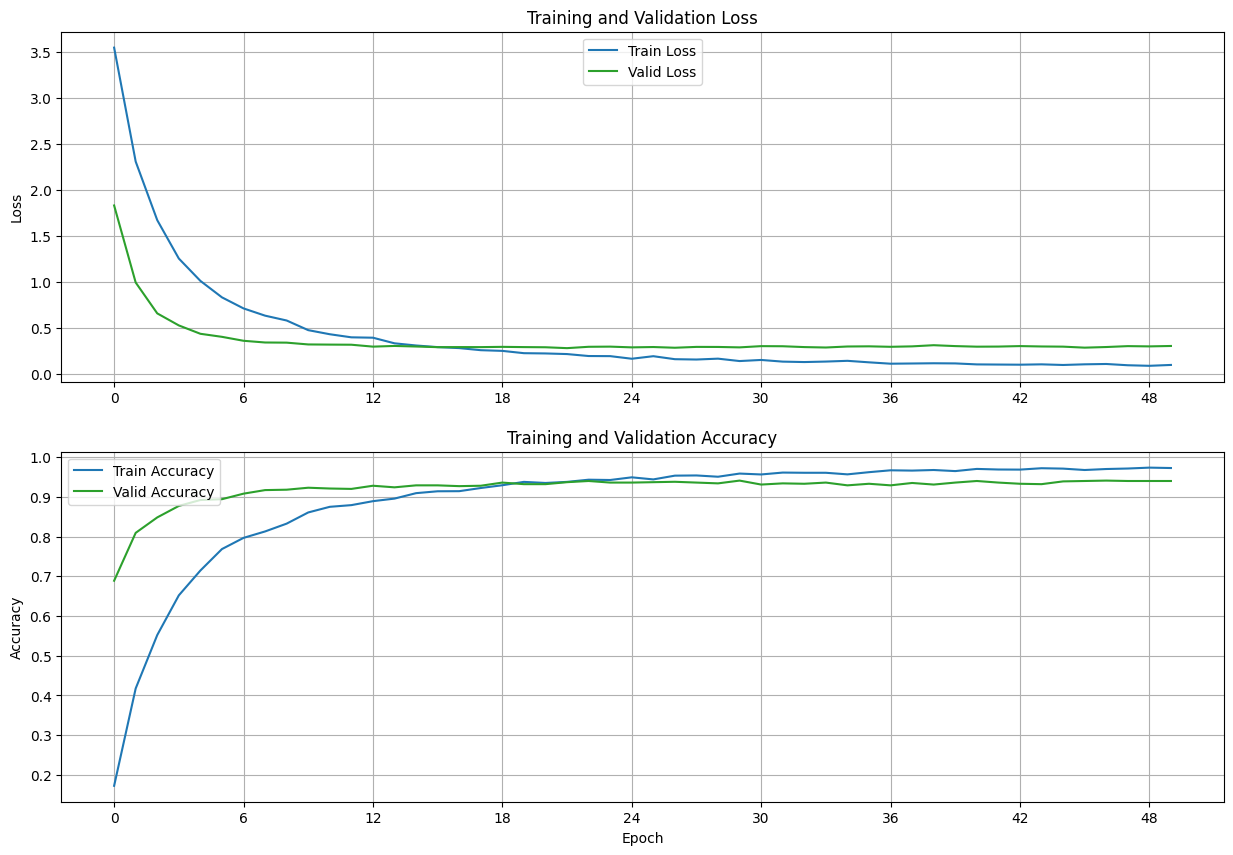

In [15]:
#Plot Loss and Accuracy graph for training
loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
    train_loss=loss,
    train_metric=accuracy,
    val_loss=val_loss,
    val_metric=val_accuracy,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

# 10. Load the model

In [16]:
def recreate_model(path, load_weights=False, config=DatasetConfig(), **kwargs):
    """
    For reloading trained model
    Args:
        path: current_version checkpoint path
        load_weights: Whether the files saved at path contains model weights
                      or the Entire model configuration
        **kwargs: use to pass additional keyword arguments to the load_model method
    Returns:
        Reinitialized Trained Model
    """

    if load_weights:
        
        # Create model architecture
        model = get_model(num_classes=config.NUM_CLASSES, input_shape=config.DATA_SHAPE)

        # Load trained model best weights.
        path = os.path.join(path, "model.keras")
        model.load_weights(path).expect_partial()
    else:
        model = tf.keras.models.load_model(path, **kwargs)

    model.summary()
    return model

In [17]:
load_version = current_version_name
checkpoint_path = os.path.join(training_config.root_checkpoint_dir, load_version) 

trained_model = recreate_model(checkpoint_path)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 75264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      19,267,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          30,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 73)                  │           8,833 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,091,050 (114.79 MB)

 Trainable params: 19,307,513 (73.65 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

 Optimizer params: 2 (12.00 B)

# 11. Inference on the test set

Found 1115 files.
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


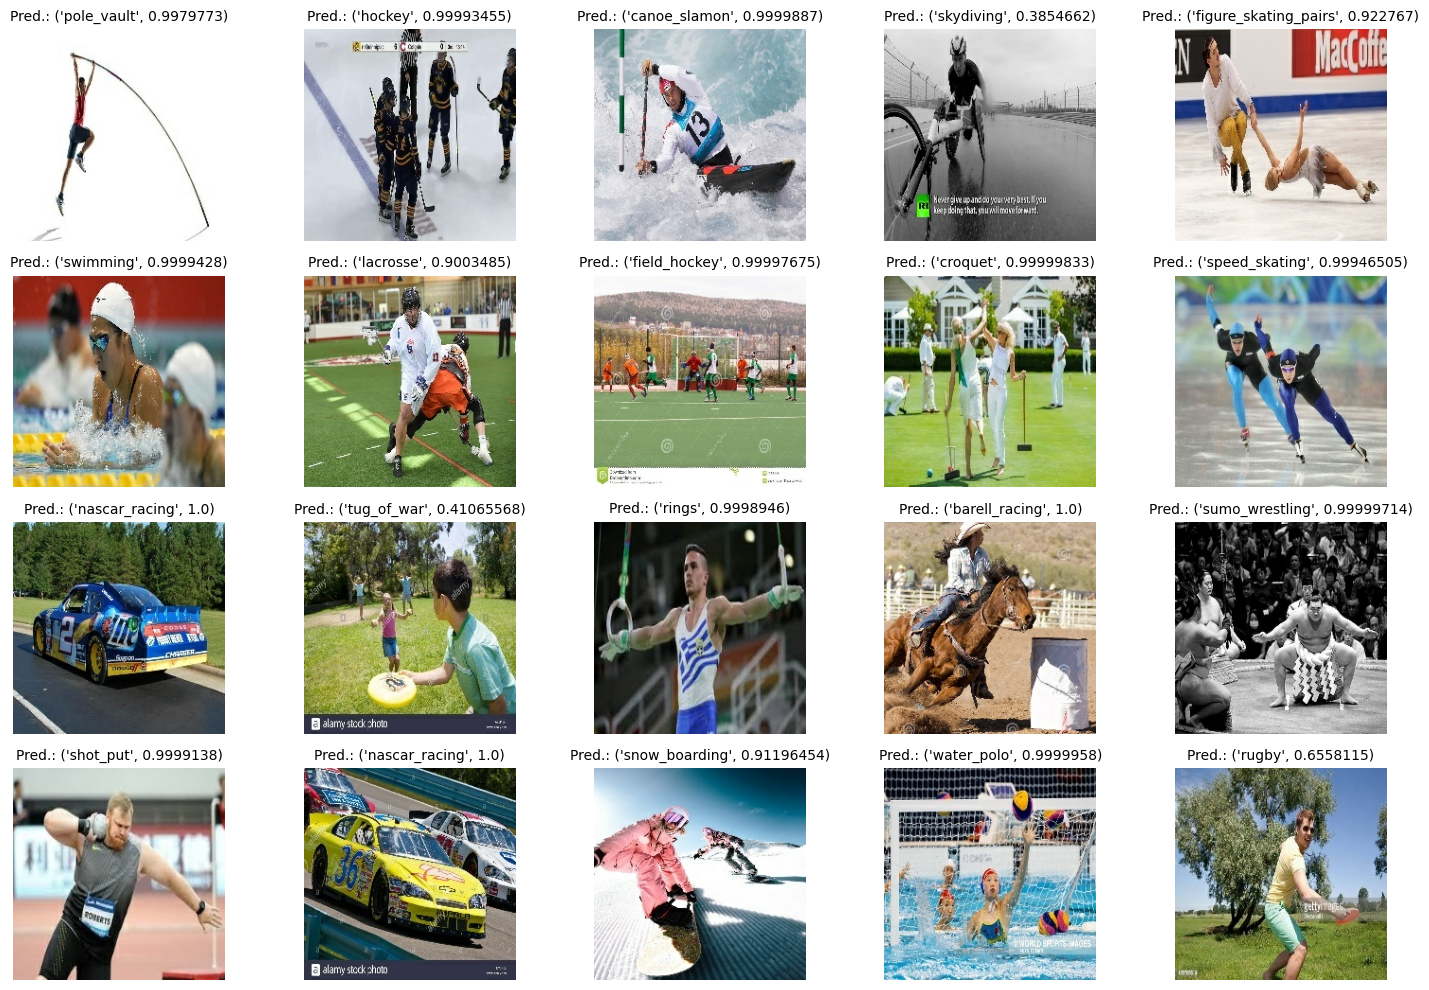

In [39]:
# Create the test dataset object
test_path = os.path.join(DatasetConfig.DATA_ROOT, "test_images")
test_dataset = image_dataset_from_directory(
    test_path,
    labels =None,
    label_mode='int',
    color_mode='rgb',
    batch_size=30, 
    image_size=DatasetConfig.DATA_SHAPE[:2],
    shuffle=False,
    )

# Get 20 samples from the dataset
num_images = 20
test_images = []
test_labels = []

for img_batch in test_dataset.take(1):  
    test_images = img_batch[:num_images]

print(len(test_images))
# Predict
pred_probs = trained_model.predict(test_images)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot
plt.figure(figsize=(15, 10))
for i in range(0,num_images):
    
    plt.subplot(4, 5, i+1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.axis('off')
    plt.title(f"Pred.: {idx_to_cls[int(pred_labels[i])], np.max(pred_probs[i])}", fontsize=10)

plt.tight_layout()
plt.show()

# 12. Create .csv file for test imge inference

In [28]:
test_path = os.path.join(DatasetConfig.DATA_ROOT, "test_images")
test_dataset = image_dataset_from_directory(
    test_path,
    labels =None,
    label_mode='int',
    color_mode='rgb',
    batch_size=1, 
    image_size=DatasetConfig.DATA_SHAPE[:2],
    shuffle=False,
    )

file_path = test_dataset.file_paths
    
#isolate the image name (ex. '1017401.jpg')
for i in range(len(file_path)):
    file_path[i] = file_path[i][-10:]
    #print("file_path ",file_path[i])
    

#Filling the dictionary for classes ==> ex : {0: 'air_hockey', 1: 'ampute_football',etc}
idx_to_cls = {}
by_class = train_names_csv.groupby("CLASS")
for a,b in enumerate(by_class['CLASS']):
    idx_to_cls[a] = b[0]


class_predicted = []
cnt = 0

test_names_csv.sort_values("ID", axis=0, ascending=True, 
                 inplace=True, na_position='first')


for index, row in enumerate(test_names_csv["ID"]):
    
    #get the image name
    image_name = row
    #get the index of the image name in the "Test" folder
    index_image_name = file_path.index(row)
    print(image_name, index_image_name)
    
    #retrieve the tf data for the image name
    for i, data in enumerate(test_dataset):
        if i == index_image_name:

            #predict the class of the test images and store it in a list
            model_predictions = trained_model.predict_on_batch(data)
            cls_predicted = np.argmax(model_predictions, axis=-1)
            class_predicted.append(idx_to_cls[int(cls_predicted)])
            cnt = cnt + 1
            print(cnt, " : ", idx_to_cls[int(cls_predicted)])

            
print("Size of class_predicted :",len(class_predicted))

# Function to add the CLASS column to the CSV file
def add_column(input_file, output_file, new_column_name, data):
    with open(input_file, 'r') as csv_input:
        with open(output_file, 'w', newline='') as csv_output:
            reader = csv.reader(csv_input)
            writer = csv.writer(csv_output)
            
            # Read the header
            header = next(reader)
            header.append(new_column_name)
            writer.writerow(header)
            
            # Add data to each row
            for row, new_data in zip(reader, data):
                row.append(new_data)
                writer.writerow(row)

#Sort the csv file for test images
test_csv_file_path = '/kaggle/input/Project_2/test.csv'
test_csv_file = pd.read_csv(test_csv_file_path)
test_csv_file.sort_values("ID", axis=0, ascending=True, 
                 inplace=True, na_position='first')
test_csv_file.to_csv('sorted_test.csv', index=False)

#Add the column "CLASS" to the csv file for the predictions
input_file = '/kaggle/working/sorted_test.csv'
output_file = '/kaggle/working/predicted_test_image_v2.csv'
new_column_name = 'CLASS'
data = class_predicted  # Data for the new column
add_column(input_file, output_file, new_column_name, data)